<a href="https://colab.research.google.com/github/MAL3X-01/DS-Unit-2-Tree-Ensembles/blob/master/DS_Sprint_Challenge_7_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

# Part 1

In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [4]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


In [5]:
df.isnull().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13958 entries, 2009-10-28 to 2019-06-05
Data columns (total 19 columns):
game_id                    13958 non-null int64
game_event_id              13958 non-null int64
player_name                13958 non-null object
period                     13958 non-null int64
minutes_remaining          13958 non-null int64
seconds_remaining          13958 non-null int64
action_type                13958 non-null object
shot_type                  13958 non-null object
shot_zone_basic            13958 non-null object
shot_zone_area             13958 non-null object
shot_zone_range            13958 non-null object
shot_distance              13958 non-null int64
loc_x                      13958 non-null int64
loc_y                      13958 non-null int64
shot_made_flag             13958 non-null int64
htm                        13958 non-null object
vtm                        13958 non-null object
season_type                13958 non-null object
s

In [0]:
df = df.reset_index()

## Feature Engineer

Homecourt Advantage: Is the home team (htm) the Golden State Warriors (GSW) ?


In [0]:
# Home Court Advantage
df['hca'] = df['htm'].apply(lambda x: 1 if x == 'GSW' else 0)

In [9]:
df.head()

,game_date,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,hca
0,2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0,1
1,2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0,1
2,2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0,1
3,2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0,1
4,2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0,1


Seconds remaining in the period: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.


In [0]:
df["tot_seconds_remaining"] = (df['minutes_remaining']*60) + df['seconds_remaining']

Seconds remaining in the game: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.


In [0]:
df['tot_second_remaining_in_game'] = (df['period'].apply(lambda x: 2160 if x == 1 
                                                        else(1440 if x == 2 
                                                        else(720 if x==3 else 0))) + 
                                                        df['tot_seconds_remaining'])

Made previous shot: Was Steph Curry's previous shot successful?

In [0]:
df['previous_shot'] = df['shot_made_flag'].shift()

df['previous_shot'] = df['previous_shot'].fillna(0)

In [13]:
df[['shot_made_flag','previous_shot']].head(10)

,shot_made_flag,previous_shot
0,0,0.0
1,1,0.0
2,0,1.0
3,0,0.0
4,0,0.0
5,0,0.0
6,1,0.0
7,1,1.0
8,1,1.0
9,1,1.0


## Train/Test Split

Do train/validate/test split. Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.

In [14]:
train = df[df['game_date'] < '2017-07-01']
val1 = df[df['game_date'] >'2017-07-01']
val = val1[val1['game_date'] < '2018-07-01']
test = df[df['game_date'] > '2018-07-01']

train.shape, test.shape, val.shape

((11081, 24), (1709, 24), (1168, 24))

In [15]:
train.head()

,game_date,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,hca,tot_seconds_remaining,tot_second_remaining_in_game,previous_shot
0,2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0,1,685,2845,0.0
1,2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0,1,571,2731,0.0
2,2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0,1,362,2522,1.0
3,2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0,1,589,2029,0.0
4,2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0,1,139,1579,0.0


Begin with baselines for classification. Your target to predict is shot_made_flag. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?

In [16]:
train['shot_made_flag'].mean()

0.47279126432632435

In [17]:
y_val = val['shot_made_flag']
y_pred = np.full_like(y_val, fill_value=train['shot_made_flag'].mean())

print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.5162671232876712


Use Ordinal Encoding or One-Hot Encoding, for the categorical features you select.

In [18]:
train.head()

,game_date,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,hca,tot_seconds_remaining,tot_second_remaining_in_game,previous_shot
0,2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0,1,685,2845,0.0
1,2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0,1,571,2731,0.0
2,2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0,1,362,2522,1.0
3,2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0,1,589,2029,0.0
4,2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0,1,139,1579,0.0


In [19]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
player_name,11081,1,Stephen Curry,11081,NaN,NaN
shot_type,11081,2,2PT Field Goal,5941,NaN,NaN
season_type,11081,2,Regular Season,9642,NaN,NaN
shot_zone_range,11081,5,24+ ft.,5065,NaN,NaN
shot_zone_area,11081,6,Center(C),4820,NaN,NaN
shot_zone_basic,11081,7,Above the Break 3,4298,NaN,NaN
htm,11081,32,GSW,5512,NaN,NaN
vtm,11081,32,GSW,5569,NaN,NaN
action_type,11081,51,Jump Shot,5375,NaN,NaN
game_date,11081,647,2013-05-06 00:00:00,35,2009-10-28 00:00:00,2017-06-12 00:00:00


In [0]:
 
target = 'shot_made_flag'

train_features = train.drop(columns=[target,'game_id','game_event_id'])

test = test.drop(columns=['game_id','game_event_id'])
                                 
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

cardinality = train_features.select_dtypes(exclude='number').nunique()

categorical_features = cardinality[cardinality <= 52].index.tolist()

features = numeric_features + categorical_features

Train a Random Forest or Logistic Regression with the features you select.

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

pipe = make_pipeline(
    ce.OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=250, min_samples_split=3, max_depth = 10,
                             criterion='gini', max_features='auto', oob_score=True,
                             random_state=5, n_jobs=-1)
)

pipe.fit(X_train, y_train)
pipe.score(X_train, y_train)

0.7484884035736847

# Part 2

Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

In [22]:
y_pred = pipe.predict(X_val)
accuracy_score(y_pred, y_val)

0.598458904109589

Get your model's test accuracy. (One time, at the end.)


In [23]:
y_pred1 = pipe.predict(X_test)
accuracy_score(y_test, y_pred1)

0.6266822703335284

Get and plot your Random Forest's feature importances or your Logistic Regression's coefficients.


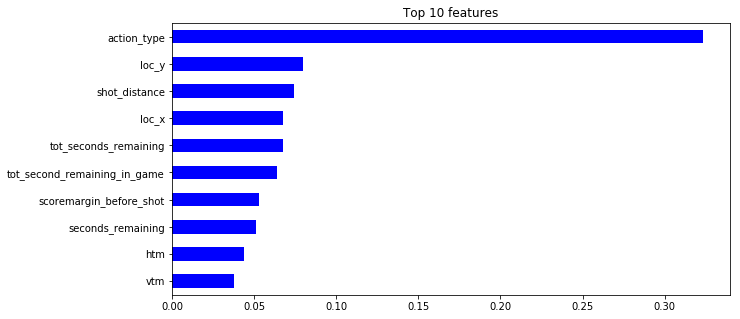

In [24]:
rf = pipe.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='blue');

Imagine this is the confusion matrix for a binary classification model. Calculate accuracy, precision, and recall for this confusion matrix:

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


In [0]:
tp = 36
tn = 85
fp = 58
fn = 8

In [26]:
accuracy = (36+85)/(36+85+58+8)
accuracy

0.6470588235294118

In [27]:
recall = (36)/((36)+(8))
recall

0.8181818181818182

In [28]:
precision = (36)/(36+58)
precision

0.3829787234042553

In [29]:
f1score = 2*((precision*recall)/(precision+recall))
f1score

0.5217391304347826

## Basketball Model

In [0]:
from sklearn.metrics import classification_report

In [31]:
accuracy_score(y_val, y_pred)

0.598458904109589

In [32]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.60      0.61       603
           1       0.58      0.59      0.59       565

    accuracy                           0.60      1168
   macro avg       0.60      0.60      0.60      1168
weighted avg       0.60      0.60      0.60      1168



In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[364, 239],
       [230, 335]])

In [34]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array([0, 1], dtype=int64)

In [35]:
pipe.named_steps['randomforestclassifier'].classes_

array([0, 1], dtype=int64)

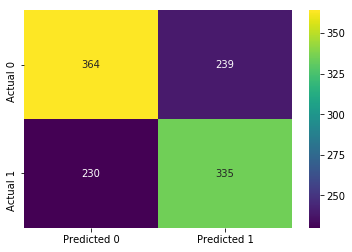

In [36]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}'  for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')
  
plot_confusion_matrix(y_val, y_pred);